# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

### Import Libraries

In [32]:
import pandas as pd
import sagemaker
import boto3
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker.estimator import Estimator
from sagemaker.amazon.amazon_estimator import get_image_uri
from time import strftime, gmtime
from sagemaker.predictor import csv_serializer, csv_deserializer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report

## Combined CSV V1

In [ ]:
#Import the dataset
data_v1 = pd.read_csv("combined_csv_v1.csv")

In [ ]:
data_v1.head()

In [ ]:
data_v1.shape

In [ ]:
data_v1.columns

In [ ]:
#Move target column to front
data_v1 = pd.concat([data_v1['target'], data_v1.drop(['target', 'Unnamed: 0'], axis=1)], axis=1)

### Split data into training, validation and testing sets (70% - 15% - 15%).

In [ ]:
training_v1 = data_v1.sample(frac=0.70, random_state=0)
testing_validation_v1 = data_v1.loc[~data_v1.index.isin(training_v1.index), :]
validation_v1 = testing_validation_v1.sample(frac=0.5, random_state=0)
testing_v1 = testing_validation_v1.loc[~testing_validation_v1.index.isin(validation_v1.index), :]

print(training_v1.shape)
print(validation_v1.shape)
print(testing_v1.shape)

In [ ]:
training_v1.to_csv('training_v1.csv', index=False, header=False)
validation_v1.to_csv('validation_v1.csv', index=False, header=False)
testing_v1.to_csv('testing_v1.csv', index=False, header=False)

In [ ]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

prefix = 'flights_delay_linear1'
training_data_path = sess.upload_data(path='training_v1.csv', key_prefix=prefix + '/input/training')
validation_data_path = sess.upload_data(path='validation_v1.csv', key_prefix=prefix + '/input/validation')
testing_data_path = sess.upload_data(path='testing_v1.csv', key_prefix=prefix + '/input/testing')

print(training_data_path)
print(validation_data_path)
print(testing_data_path)

### Use linear learner estimator to build a classifcation model.

In [ ]:
region = boto3.Session().region_name    
container = get_image_uri(region, 'linear-learner')

role = sagemaker.get_execution_role() 

ll_estimator = Estimator(container,
    role=role, 
    train_instance_count=1,
    train_instance_type='ml.c5.9xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix)
)

ll_estimator.set_hyperparameters(predictor_type='binary_classifier', mini_batch_size=32)

In [ ]:
training_data_channel   = sagemaker.TrainingInput(s3_data=training_data_path, content_type='text/csv')
validation_data_channel = sagemaker.TrainingInput(s3_data=validation_data_path, content_type='text/csv')
testing_data_channel    = sagemaker.TrainingInput(s3_data=testing_data_path, content_type='text/csv')

ll_data = {'train': training_data_channel, 'validation': validation_data_channel}

In [ ]:
ll_estimator.fit(ll_data)

### Host the model on another instance

In [ ]:
%%bash -s "$ll_estimator.output_path"
aws s3 ls --recursive $1

In [ ]:
timestamp = strftime('%d-%H-%M-%S', gmtime())

endpoint_name = 'linear-learner-1-'+timestamp
print(endpoint_name)

In [ ]:
ll_predictor.delete_endpoint()

### Perform batch transform to evaluate the model on testing data

In [ ]:
testing_v1 = pd.read_csv("testing_v1.csv", header=None)
batch_X = testing_v1.iloc[:,1:]
batch_X.head()

In [ ]:
s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [ ]:
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [ ]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

ll_transformer = ll_estimator.transformer(instance_count=1,
                                          instance_type='ml.c5.9xlarge',
                                          strategy='MultiRecord',
                                          assemble_with='Line',
                                          output_path=batch_output)

ll_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
ll_transformer.wait()

In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])
target_predicted.head(5)

In [ ]:
def binary_convert(x):
    threshold = 0.65
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['binary'] = target_predicted['class'].apply(binary_convert)

print(target_predicted.head(10))
testing_v1.head(10)

### Report the performance metrics that you see better test the model performance

In [ ]:
#Confusion Matrix
def plot_confusion_matrix(test_labels, target_predicted):
    cm = confusion_matrix(test_labels, target_predicted, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.grid(False) #Remove white lines in plot
    plt.show()

In [ ]:
#ROC Curve
def plot_roc(test_labels, target_predicted):
    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
plot_confusion_matrix(testing_v1.iloc[:,0], target_predicted.binary)

In [ ]:
plot_roc(testing_v1.iloc[:,0], target_predicted.binary)

In [ ]:
print(classification_report(testing_v1.iloc[:,0], target_predicted.binary))

## Combined CSV V2

In [ ]:
#Import the dataset
data_v2 = pd.read_csv("combined_csv_v2.csv")

In [ ]:
data_v2.head()

In [ ]:
data_v2.shape

In [ ]:
data_v2.columns

In [ ]:
#Move target column to front
data_v2 = pd.concat([data_v2['target'], data_v2.drop(['target', 'Unnamed: 0'], axis=1)], axis=1)

### Split data into training, validation and testing sets (70% - 15% - 15%).

In [ ]:
training_v2 = data_v2.sample(frac=0.70, random_state=0)
testing_validation_v2 = data_v2.loc[~data_v2.index.isin(training_v2.index), :]
validation_v2 = testing_validation_v2.sample(frac=0.5, random_state=0)
testing_v2 = testing_validation_v2.loc[~testing_validation_v2.index.isin(validation_v2.index), :]

print(training_v2.shape)
print(validation_v2.shape)
print(testing_v2.shape)

In [ ]:
training_v2.to_csv('training_v2.csv', index=False, header=False)
validation_v2.to_csv('validation_v2.csv', index=False, header=False)
testing_v2.to_csv('testing_v2.csv', index=False, header=False)

In [ ]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

prefix = 'flights_delay_linear2'
training_data_path = sess.upload_data(path='training_v2.csv', key_prefix=prefix + '/input/training')
validation_data_path = sess.upload_data(path='validation_v2.csv', key_prefix=prefix + '/input/validation')
testing_data_path = sess.upload_data(path='testing_v2.csv', key_prefix=prefix + '/input/testing')

print(training_data_path)
print(validation_data_path)
print(testing_data_path)

### Use linear learner estimator to build a classifcation model.

In [ ]:
region = boto3.Session().region_name    
container = get_image_uri(region, 'linear-learner')

role = sagemaker.get_execution_role() 

ll_estimator = Estimator(container,
    role=role, 
    train_instance_count=1,
    train_instance_type='ml.c5.9xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix)
)

ll_estimator.set_hyperparameters(predictor_type='binary_classifier', mini_batch_size=32)

In [ ]:
training_data_channel   = sagemaker.TrainingInput(s3_data=training_data_path, content_type='text/csv')
validation_data_channel = sagemaker.TrainingInput(s3_data=validation_data_path, content_type='text/csv')
testing_data_channel    = sagemaker.TrainingInput(s3_data=testing_data_path, content_type='text/csv')

ll_data = {'train': training_data_channel, 'validation': validation_data_channel}

In [ ]:
ll_estimator.fit(ll_data)

### Host the model on another instance

In [ ]:
%%bash -s "$ll_estimator.output_path"
aws s3 ls --recursive $1

In [ ]:
timestamp = strftime('%d-%H-%M-%S', gmtime())

endpoint_name = 'linear-learner-2-'+timestamp
print(endpoint_name)

In [ ]:
ll_predictor.delete_endpoint()

### Perform batch transform to evaluate the model on testing data

In [ ]:
testing_v2 = pd.read_csv("testing_v2.csv", header=None)
batch_X = testing_v2.iloc[:,1:]
batch_X.head()

In [ ]:
s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [ ]:
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [ ]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

ll_transformer = ll_estimator.transformer(instance_count=1,
                                          instance_type='ml.c5.9xlarge',
                                          strategy='MultiRecord',
                                          assemble_with='Line',
                                          output_path=batch_output)

ll_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
ll_transformer.wait()

In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])
target_predicted.head(5)

In [ ]:
def binary_convert(x):
    threshold = 0.65
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['binary'] = target_predicted['class'].apply(binary_convert)

print(target_predicted.head(10))
testing_v2.head(10)

### Report the performance metrics that you see better test the model performance

In [ ]:
#Confusion Matrix
def plot_confusion_matrix(test_labels, target_predicted):
    cm = confusion_matrix(test_labels, target_predicted, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.grid(False) #Remove white lines in plot
    plt.show()

In [ ]:
#ROC Curve
def plot_roc(test_labels, target_predicted):
    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
plot_confusion_matrix(testing_v2.iloc[:,0], target_predicted.binary)

In [ ]:
plot_roc(testing_v2.iloc[:,0], target_predicted.binary)

In [ ]:
print(classification_report(testing_v2.iloc[:,0], target_predicted.binary))

In [ ]:
# Write the final comments here and turn the cell type into markdown

# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

## Combined CSV V1

In [ ]:
#Import the dataset
data_v1 = pd.read_csv("combined_csv_v1.csv")

In [ ]:
data_v1.head()

In [ ]:
data_v1.shape

In [ ]:
data_v1.columns

In [ ]:
#Move target column to front
data_v1 = pd.concat([data_v1['target'], data_v1.drop(['target', 'Unnamed: 0'], axis=1)], axis=1)

### Split data into training, validation and testing sets (70% - 15% - 15%).

In [ ]:
training_v1 = data_v1.sample(frac=0.70, random_state=0)
testing_validation_v1 = data_v1.loc[~data_v1.index.isin(training_v1.index), :]
validation_v1 = testing_validation_v1.sample(frac=0.5, random_state=0)
testing_v1 = testing_validation_v1.loc[~testing_validation_v1.index.isin(validation_v1.index), :]

print(training_v1.shape)
print(validation_v1.shape)
print(testing_v1.shape)

In [ ]:
training_v1.to_csv('training_v1.csv', index=False, header=False)
validation_v1.to_csv('validation_v1.csv', index=False, header=False)
testing_v1.to_csv('testing_v1.csv', index=False, header=False)

In [3]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

prefix = 'flights_delay_xgboost1'
training_data_path = sess.upload_data(path='training_v1.csv', key_prefix=prefix + '/input/training')
validation_data_path = sess.upload_data(path='validation_v1.csv', key_prefix=prefix + '/input/validation')
testing_data_path = sess.upload_data(path='testing_v1.csv', key_prefix=prefix + '/input/testing')

print(training_data_path)
print(validation_data_path)
print(testing_data_path)

s3://sagemaker-us-east-1-001681017689/flights_delay_xgboost1/input/training/training_v1.csv
s3://sagemaker-us-east-1-001681017689/flights_delay_xgboost1/input/validation/validation_v1.csv
s3://sagemaker-us-east-1-001681017689/flights_delay_xgboost1/input/testing/testing_v1.csv


### Use xgboost estimator to build a classifcation model.

In [4]:
region = boto3.Session().region_name    
container = get_image_uri(region, 'xgboost', repo_version='1.0-1')

role = sagemaker.get_execution_role() 

xgb_estimator = Estimator(container,
    role=role, 
    train_instance_count=1,
    train_instance_type='ml.c5.9xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix)
)

xgb_estimator.set_hyperparameters(objective='binary:logistic',
                                 num_round=200,
                                 early_stopping_rounds=10)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [5]:
training_data_channel   = sagemaker.TrainingInput(s3_data=training_data_path, content_type='text/csv')
validation_data_channel = sagemaker.TrainingInput(s3_data=validation_data_path, content_type='text/csv')
testing_data_channel = sagemaker.TrainingInput(s3_data=testing_data_path, content_type='text/csv')

xgb_data = {'train': training_data_channel, 'validation': validation_data_channel}

In [6]:
xgb_estimator.fit(xgb_data)

2022-11-05 00:23:35 Starting - Starting the training job...
2022-11-05 00:23:58 Starting - Preparing the instances for trainingProfilerReport-1667607815: InProgress
......
2022-11-05 00:25:05 Downloading - Downloading input data......
2022-11-05 00:25:59 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[00:25:57] 1144913x93 matrix with 106476909 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter o

### Host the model on another instance

In [7]:
timestamp = strftime('%d-%H-%M-%S', gmtime())

endpoint_name = 'xgb-demo-'+timestamp
print(endpoint_name)

xgb-demo-05-00-28-00


In [8]:
xgb_predictor = xgb_estimator.deploy(endpoint_name=endpoint_name, 
                        initial_instance_count=1, 
                        instance_type='ml.c5.9xlarge')

-----!

In [9]:
xgb_predictor.delete_endpoint()

### Perform batch transform to evaluate the model on testing data

In [10]:
testing_v1 = pd.read_csv("testing_v1.csv", header=None)
batch_X = testing_v1.iloc[:,1:]
batch_X.head()

,1,2,3,4,5,6,7,8,9,10,...,84,85,86,87,88,89,90,91,92,93
0,1464.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1464.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1464.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1464.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1464.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [15]:
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [16]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_estimator.transformer(instance_count=1,
                                            instance_type='ml.c5.9xlarge',
                                            strategy='MultiRecord',
                                            assemble_with='Line',
                                            output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

............................[2022-11-05:00:40:15:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-05:00:40:15:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-05:00:40:15:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2022-11-05 00:40:15 +0000] [82] [INFO] Starting gunicor

In [17]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])
target_predicted.head(5)

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3524: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,class
0,0.140457
1,0.105327
2,0.125894
3,0.115904
4,0.077046


In [20]:
def binary_convert(x):
    threshold = 0.65
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['binary'] = target_predicted['class'].apply(binary_convert)

print(target_predicted.head(10))
testing_v1.head(10)

      class  binary
0  0.140457       0
1  0.105327       0
2  0.125894       0
3  0.115904       0
4  0.077046       0
5  0.043192       0
6  0.174943       0
7  0.341822       0
8  0.190818       0
9  0.116052       0


,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,0.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1.0,1464.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Report the performance metrics that you see better test the model performance

In [21]:
#Confusion Matrix
def plot_confusion_matrix(test_labels, target_predicted):
    cm = confusion_matrix(test_labels, target_predicted, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.grid(False) #Remove white lines in plot
    plt.show()

In [22]:
#ROC Curve
def plot_roc(test_labels, target_predicted):
    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

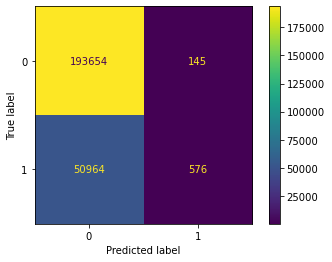

In [29]:
plot_confusion_matrix(testing_v1.iloc[:,0], target_predicted.binary)

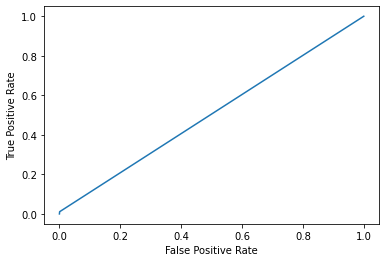

In [30]:
plot_roc(testing_v1.iloc[:,0], target_predicted.binary)

In [33]:
print(classification_report(testing_v1.iloc[:,0], target_predicted.binary))

              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    193799
         1.0       0.80      0.01      0.02     51540

    accuracy                           0.79    245339
   macro avg       0.80      0.51      0.45    245339
weighted avg       0.79      0.79      0.70    245339



## Combined CSV V2

In [ ]:
#Import the dataset
data_v2 = pd.read_csv("combined_csv_v2.csv")

In [ ]:
data_v2.head()

In [ ]:
data_v2.shape

In [ ]:
data_v2.columns

In [ ]:
#Move target column to front
data_v2 = pd.concat([data_v2['target'], data_v2.drop(['target', 'Unnamed: 0'], axis=1)], axis=1)

### Split data into training, validation and testing sets (70% - 15% - 15%).

In [ ]:
training_v2 = data_v2.sample(frac=0.70, random_state=0)
testing_validation_v2 = data_v2.loc[~data_v2.index.isin(training_v2.index), :]
validation_v2 = testing_validation_v2.sample(frac=0.5, random_state=0)
testing_v2 = testing_validation_v2.loc[~testing_validation_v2.index.isin(validation_v2.index), :]

print(training_v2.shape)
print(validation_v2.shape)
print(testing_v2.shape)

In [ ]:
training_v2.to_csv('training_v2.csv', index=False, header=False)
validation_v2.to_csv('validation_v2.csv', index=False, header=False)
testing_v2.to_csv('testing_v2.csv', index=False, header=False)

In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

prefix = 'flights_delay_xgboost2'
training_data_path = sess.upload_data(path='training_v2.csv', key_prefix=prefix + '/input/training')
validation_data_path = sess.upload_data(path='validation_v2.csv', key_prefix=prefix + '/input/validation')
testing_data_path = sess.upload_data(path='testing_v2.csv', key_prefix=prefix + '/input/testing')

print(training_data_path)
print(validation_data_path)
print(testing_data_path)

s3://sagemaker-us-east-1-001681017689/flights_delay_xgboost2/input/training/training_v2.csv
s3://sagemaker-us-east-1-001681017689/flights_delay_xgboost2/input/validation/validation_v2.csv
s3://sagemaker-us-east-1-001681017689/flights_delay_xgboost2/input/testing/testing_v2.csv


### Use xgboost estimator to build a classifcation model.

In [3]:
region = boto3.Session().region_name    
container = get_image_uri(region, 'xgboost', repo_version='1.0-1')

role = sagemaker.get_execution_role() 

xgb_estimator = Estimator(container,
    role=role, 
    train_instance_count=1,
    train_instance_type='ml.c5.9xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix)
)

xgb_estimator.set_hyperparameters(objective='binary:logistic',
                                 num_round=200,
                                 early_stopping_rounds=10)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [4]:
training_data_channel   = sagemaker.TrainingInput(s3_data=training_data_path, content_type='text/csv')
validation_data_channel = sagemaker.TrainingInput(s3_data=validation_data_path, content_type='text/csv')
testing_data_channel    = sagemaker.TrainingInput(s3_data=testing_data_path, content_type='text/csv')

xgb_data = {'train': training_data_channel, 'validation': validation_data_channel}

In [5]:
xgb_estimator.fit(xgb_data)

2022-11-04 05:29:35 Starting - Starting the training job...
2022-11-04 05:29:59 Starting - Preparing the instances for trainingProfilerReport-1667539775: InProgress
......
2022-11-04 05:31:02 Downloading - Downloading input data...
2022-11-04 05:31:22 Training - Downloading the training image...
2022-11-04 05:31:59 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[05:32:00] 1144913x85 matrix with 97317605 entries loaded from /opt/ml/input/data/train?format=c

### Host the model on another instance

In [6]:
timestamp = strftime('%d-%H-%M-%S', gmtime())

endpoint_name = 'xgb-demo-'+timestamp
print(endpoint_name)

xgb-demo-04-05-33-39


In [7]:
xgb_predictor = xgb_estimator.deploy(endpoint_name=endpoint_name, 
                        initial_instance_count=1, 
                        instance_type='ml.c5.9xlarge')

-----!

In [ ]:
xgb_predictor.delete_endpoint()

### Perform batch transform to evaluate the model on testing data

In [ ]:
testing_v2 = pd.read_csv("testing_v2.csv", header=None)
batch_X = testing_v2.iloc[:,1:]
batch_X.head()

In [ ]:
s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [ ]:
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [ ]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_estimator.transformer(instance_count=1,
                                            instance_type='ml.c5.9xlarge',
                                            strategy='MultiRecord',
                                            assemble_with='Line',
                                            output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])
target_predicted.head(5)

In [ ]:
def binary_convert(x):
    threshold = 0.65
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['binary'] = target_predicted['class'].apply(binary_convert)

print(target_predicted.head(10))
testing_v2.head(10)

### Report the performance metrics that you see better test the model performance

In [ ]:
#Confusion Matrix
def plot_confusion_matrix(test_labels, target_predicted):
    cm = confusion_matrix(test_labels, target_predicted, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.grid(False) #Remove white lines in plot
    plt.show()

In [ ]:
#ROC Curve
def plot_roc(test_labels, target_predicted):
    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
plot_confusion_matrix(testing_v2.iloc[:,0], target_predicted.binary)

In [ ]:
plot_roc(testing_v2.iloc[:,0], target_predicted.binary)

In [ ]:
print(classification_report(testing_v2.iloc[:,0], target_predicted.binary))

### Write down your observation on the difference between the performance of using the simple and ensemble models.

Couldn't compare between the Linear Learner and XGBoost because I couldn't get the Linear Learner to complete training because training would take longer than the 2 hours allocated for the Lab Session.